Average accuracies:
arc_challenge:
  meta-llama__Llama-2-7b-hf: 0.4625
  __pool.ssd__assets__models__meta-llama__Llama-2-7b-hf-watermarked-greenlist-bias-k235: 0.4465
  __pool.ssd__assets__models__meta-llama__Llama-2-7b-hf-watermarked-gaussmark-sigma0.04: 0.4525
  cygu__llama-2-7b-logit-watermark-distill-kgw-k1-gamma0.25-delta2: 0.4556
super-glue-lm-eval-v1:
  meta-llama__Llama-2-7b-hf: 0.6347
  __pool.ssd__assets__models__meta-llama__Llama-2-7b-hf-watermarked-greenlist-bias-k235: 0.6416
  __pool.ssd__assets__models__meta-llama__Llama-2-7b-hf-watermarked-gaussmark-sigma0.04: 0.6305
  cygu__llama-2-7b-logit-watermark-distill-kgw-k1-gamma0.25-delta2: 0.6752


/tmp/ipykernel_1755525/911776180.py:124: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("tab10", 8)


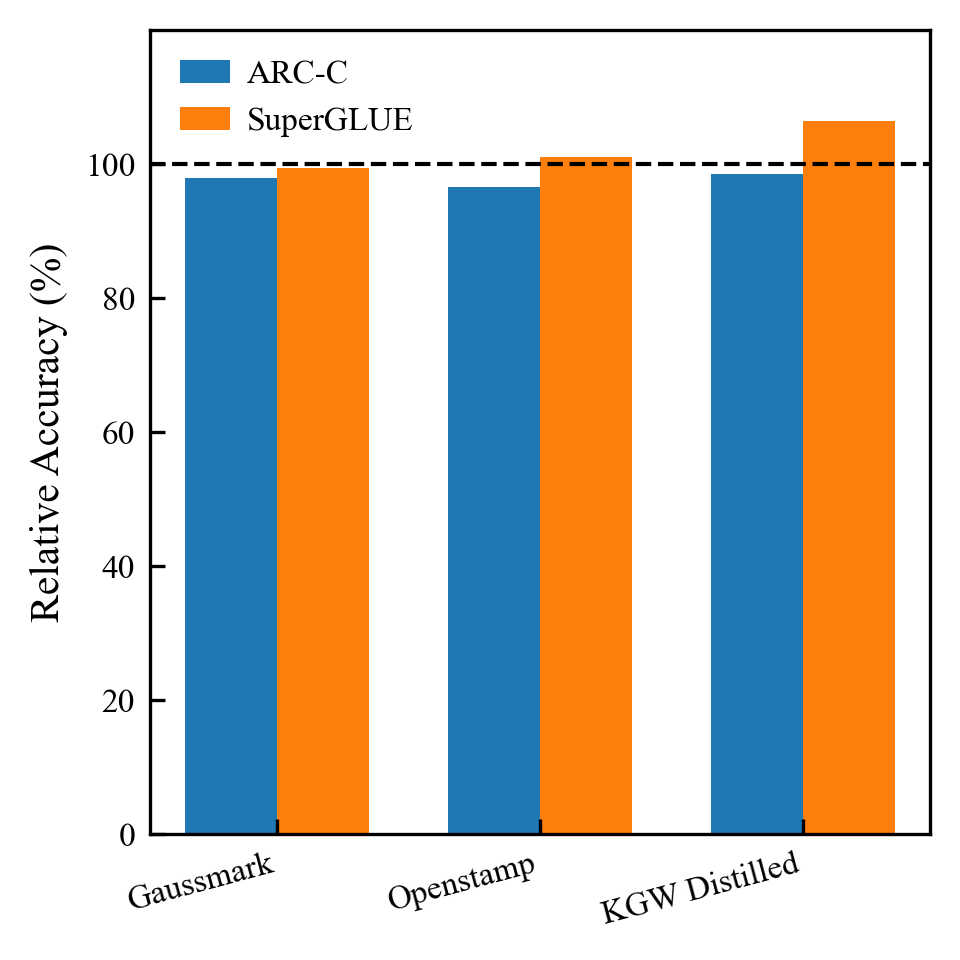

In [10]:
import os
import json
import re
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import matplotlib.cm as cm


# Root directory for benchmark results
ROOT_DIR = "../results"  # ← Change this

BASELINE_NAME = "meta-llama__Llama-2-7b-hf"
BENCHMARKS = ["arc_challenge", "super-glue-lm-eval-v1"]

# Short model labels for plot
def get_readable_label(model_type):
    if model_type == BASELINE_NAME:
        return "Baseline"
    elif "greenlist" in model_type:
        return "Openstamp"
    elif "gaussmark" in model_type:
        return "Gaussmark"
    elif "cygu" in model_type:
        return "KGW Distilled"
    else:
        return model_type.split("__")[-1]  # fallback

# Normalize model type by stripping seed suffix
def extract_model_type(model_dir):
    match = re.match(r"^(.*?)-seed\d+$", model_dir)
    return match.group(1) if match else model_dir

# Load accuracy values
results = defaultdict(lambda: defaultdict(list))

def extract_superglue_score(data):
    task_scores = []
    task_errors = []

    for task_name, task_result in data["results"].items():
        # Prefer acc, fallback to f1
        if "acc,none" in task_result:
            score = task_result["acc,none"]
            stderr = task_result.get("acc_stderr,none", 0)
        elif "f1,none" in task_result and task_result["f1,none"] != "N/A":
            score = task_result["f1,none"]
            stderr = task_result.get("f1_stderr,none", 0)
        else:
            continue
        task_scores.append(score)
        task_errors.append(stderr if isinstance(stderr, (int, float)) else 0)

    if task_scores:
        avg_score = np.mean(task_scores)
        stderr = np.sqrt((np.array(task_errors) ** 2).mean()) / np.sqrt(len(task_errors))
        return avg_score, stderr
    else:
        return None, None
    
for benchmark in BENCHMARKS:
    benchmark_dir = os.path.join(ROOT_DIR, benchmark)
    if not os.path.isdir(benchmark_dir):
        continue

    for model_dir in os.listdir(benchmark_dir):
        model_path = os.path.join(benchmark_dir, model_dir)
        if not os.path.isdir(model_path):
            continue

        for file in os.listdir(model_path):
            if file.startswith("results_") and file.endswith(".json"):
                file_path = os.path.join(model_path, file)
                try:
                    with open(file_path, "r") as f:
                        data = json.load(f)
                        if benchmark == "super-glue-lm-eval-v1":
                            acc, stderr = extract_superglue_score(data)
                        else:
                            acc = data["results"][benchmark]["acc_norm,none"]
                        model_type = (
                            model_dir if model_dir == BASELINE_NAME else extract_model_type(model_dir)
                        )
                        results[benchmark][model_type].append(acc)
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")

# Average accuracy per model type
avg_acc = {
    benchmark: {
        model_type: np.mean(accs)
        for model_type, accs in model_dict.items()
    }
    for benchmark, model_dict in results.items()
}

print("Average accuracies:")
for benchmark, model_dict in avg_acc.items():
    print(f"{benchmark}:")
    for model_type, acc in model_dict.items():
        print(f"  {model_type}: {acc:.4f}")

# Compute relative accuracy (% of baseline)
relative_acc = defaultdict(dict)
all_model_types = set()

for benchmark in BENCHMARKS:
    baseline = avg_acc[benchmark].get(BASELINE_NAME)
    if not baseline:
        continue
    for model_type, acc in avg_acc[benchmark].items():
        rel = acc / baseline * 100
        relative_acc[benchmark][model_type] = rel
        if model_type != BASELINE_NAME:
            all_model_types.add(model_type)

# Plotting
model_types = sorted(all_model_types)
readable_labels = [get_readable_label(m) for m in model_types]
x = np.arange(len(model_types))
width = 0.35

plt.style.use("aaai.mplstyle")
colors = cm.get_cmap("tab10", 8)
benchmark_labels = {
    "arc_challenge": "ARC-C",
    "super-glue-lm-eval-v1": "SuperGLUE"
}

fig, ax = plt.subplots(figsize=(3.3, 3.3))

for i, benchmark in enumerate(BENCHMARKS):
    values = [relative_acc[benchmark].get(m, 0) for m in model_types]
    ax.bar(x + i * width, values, width, label=benchmark_labels.get(benchmark, benchmark), 
           color=colors(i))

ax.set_ylabel("Relative Accuracy (%)")
ax.set_xticks(x + width / 2)
ax.set_xticklabels(readable_labels, rotation=15, ha="right")
ax.axhline(100, color="black", linestyle="--", linewidth=1)
ax.set_ylim(0, 120)
# Omit 120 as a y-tick
ax.set_yticks(np.arange(0, 101, 20))
ax.legend()
plt.tight_layout()
# Save plot
plt.savefig("../plots/relative_ds_accuracy_plot.pdf", bbox_inches="tight")
